# Introduction

- AutoGen 0.4 released in January 2025
- From the ground-up rewrite adopting an asynchronous, event-driven architecture to address issues such as observability, flexibility, interactive control, and scale.

# AutoGen Drama

- Several of the original developers of AutoGen left Microsoft and split off in late 2024 to create a fork of AutoGen
- Called AG2 or AgentOS 2, compatible with earlier AutoGen 0.2
- If you pip install autogen, you get AG2!

# Agent Core

An event-driven programming framework for building scalable multi-agent AI systems. Example scenarios:
- Deterministic and dynamic agentic workflows for business processes.
- Research on multi-agent collaboration.
- Distributed agents for multi-language applications.

# AutoGen AgentChat

- A programming framework for building conversational single and multi-agent applications. 
- Built on Core. 
- Requires Python 3.10+

## Models


#### Overview

- In many cases, agents need access to LLM model services such as OpenAI, Azure OpenAI, or local models.
- `autogen-core` implements a protocol for model clients and `autogen-ext` implements a set of model clients for popular model services. 
- `AgentChat` can use these model clients to interact with model services.

#### OpenAI

You can use this client with most models hosted on OpenAI-compatible endpoints. Try it out first.

In [ ]:
!pip install "autogen-ext[openai]"

In [ ]:
from autogen_ext.models.openai import OpenAIChatCompletionClient
import tiktoken
openai_model_client = OpenAIChatCompletionClient(
    model="gpt-4o-mini",
    # api_key="sk-...", # Optional if you have an OPENAI_API_KEY environment variable set.
)

In [ ]:
from autogen_core.models import UserMessage

result = await openai_model_client.create([UserMessage(content="What is the capital of France?", source="user")])
print(result)
await openai_model_client.close()

#### Azure OpenAI 

In [ ]:
!pip install "autogen-ext[openai,azure]"

- To use the client, you need to provide your deployment id, Azure Cognitive Services endpoint, api version, and model capabilities. 
- For authentication, you can either provide an API key or an Azure Active Directory (AAD) token credential.
- The identity used must be assigned the Cognitive Services OpenAI User role.

In [ ]:
from autogen_core.models import UserMessage
from autogen_ext.auth.azure import AzureTokenProvider
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential

# Create the token provider
token_provider = AzureTokenProvider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default",
)

az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment="{your-azure-deployment}",
    model="{model-name, such as gpt-4o}",
    api_version="2024-06-01",
    azure_endpoint="https://{your-custom-endpoint}.openai.azure.com/",
    azure_ad_token_provider=token_provider,  # Optional if you choose key-based authentication.
    # api_key="sk-...", # For key-based authentication.
)

result = await az_model_client.create([UserMessage(content="What is the capital of France?", source="user")])
print(result)
await az_model_client.close()


#### Ollama (experimental)

In [ ]:
!pip install -U "autogen-ext[ollama]"

In [ ]:
from autogen_ext.models.ollama import OllamaChatCompletionClient
ollamamodel_client = OllamaChatCompletionClient(model="llama3.2")

#### Azure AI Foundry

Azure AI Foundry (previously known as Azure AI Studio) offers models hosted on Azure. 

In [ ]:
!pip install "autogen-ext[azure]"

In [ ]:
import os

from autogen_core.models import UserMessage
from autogen_ext.models.azure import AzureAIChatCompletionClient
from azure.core.credentials import AzureKeyCredential

client = AzureAIChatCompletionClient(
    model="Phi-4",
    endpoint="https://models.github.ai/inference",
    # To authenticate with the model you will need to generate a personal access token (PAT) in your GitHub settings.
    # Create your PAT token by following instructions here: https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens
    credential=AzureKeyCredential(os.environ["GITHUB_TOKEN"]),
    model_info={
        "json_output": False,
        "function_calling": False,
        "vision": False,
        "family": "unknown",
        "structured_output": False,
    },
)

result = await client.create([UserMessage(content="What is the capital of France?", source="user")])
print(result)
await client.close()


### Log Model Calls

- AutoGen uses standard Python logging module to log events like model calls and responses. 
- The logger name is `autogen_core.EVENT_LOGGER_NAME`, and the event type is `LLMCall`.

In [ ]:
import logging

from autogen_core import EVENT_LOGGER_NAME

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(EVENT_LOGGER_NAME)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

## Messages
- `messages` facilitate communication and information exchange with other agents, orchestrators, and applications. 

### Types of Messages

At a high level, messages in `AgentChat` can be categorized into two types: `agent-agent` messages and an `agent's internal events and messages`.

#### Agent-Agent Messages

- They belong to subclasses of the base class `BaseChatMessage`.
- Concrete subclasses covers basic text and multimodal communication

##### TextMessage

In [ ]:
from autogen_agentchat.messages import TextMessage
message = TextMessage(content="I'd like to go to London", source="user")
message

##### MultiModalMessage

In [ ]:
from io import BytesIO
import requests
from autogen_agentchat.messages import TextMessage, MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from IPython.display import display, Markdown
from pydantic import BaseModel, Field
from typing import Literal

load_dotenv(override=True)

What is `AGImage`?
- **AGImage** is AutoGen's specialized image wrapper class that enables multimodal AI agents to work with image data. It's imported from `autogen_core` and serves as a bridge between standard Python image formats (like PIL Images) and AutoGen's agent communication system.
- In the code example, **AGImage** is being used to convert a PIL (Python Imaging Library) image into AutoGen's native image format. The process starts by downloading an image from a URL using the `requests` library, converting the response content into a BytesIO stream, opening it as a PIL Image, and then wrapping it with **AGImage**. This transformation is necessary because AutoGen agents need images in a specific format to include them in multimodal messages.
- **AGImage** acts as a standardized container that ensures images can be properly serialized, transmitted between agents, and processed by vision-capable language models. It abstracts away the complexity of handling different image formats and provides a consistent interface for agents to work with visual data.

In [ ]:
url = "https://edwarddonner.com/wp-content/uploads/2024/10/from-software-engineer-to-AI-DS.jpeg"

pil_image = Image.open(BytesIO(requests.get(url).content))
img = AGImage(pil_image)
img

In [ ]:
message = MultiModalMessage(
    content=["Describe the content of this image in detail", img],
    source="user")

In [ ]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
image_description_agent = AssistantAgent(
    name="image_description_agent",
    model_client=model_client,
    system_message="You are a helpful assistant for describing images.",
    model_client_stream=True)

response = await image_description_agent.on_messages([message], cancellation_token=CancellationToken())
reply = response.chat_message.content
display(Markdown(reply))

#### Agent Internal Events

- AgentChat also supports the concept of `events` - messages that are internal to an agent
- These messages are used to communicate events and information on actions within the agent itself
- Base class `BaseAgentEvent`
- Examples:
  - `ToolCallRequestEvent`: Indicates that a request was made to call a tool.
  - `ToolCallExecutionEvent`: Contains the results of tool calls.
- `events` are created by the agent itself and are contained in the `inner_messages` field of the `Response` returned from `on_messages`

#### Custom Message Types

- You can create custom message types by subclassing the base class `BaseChatMessage` or `BaseAgentEvent`.
- Custom message types are useful when you write custom agents.

## Agents

### Overview

- AutoGen AgentChat provides a set of preset Agents, each with variations in how an agent might respond to messages. 
- All agents share the following attributes and methods:
  - `name`: The unique name of the agent.
  - `description`: The description of the agent in text.
  - `run`: 
    - The method that runs the agent given a task as a string or a list of messages, and returns a TaskResult. 
    - Agents are expected to be stateful and this method is expected to be called with new messages, not complete history.
  - `run_stream`: Same as run() but returns an iterator of messages that subclass `BaseAgentEvent` or `BaseChatMessage` followed by a `TaskResult` as the last item.

### Assistant Agent

- `AssistantAgent` is a built-in agent that uses a language model and has the ability to use tools.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [ ]:
from autogen_core import CancellationToken

response = await agent.on_messages([message], cancellation_token=CancellationToken())
response.chat_message.content

# CancellationToken: 
# 1. Provides a mechanism for cooperative cancellation of asynchronous operations. 
# 2. This is a common pattern in async programming that allows long-running operations to be gracefully interrupted when needed.
# 3. When a caller wants to cancel an ongoing operation (perhaps due to a timeout, user request, or system shutdown), they can signal this through the cancellation token. 
# 4. The async method can then check this token periodically and respond appropriately by cleaning up resources and exiting early.
# 5. Without a cancellation mechanism, there would be no way to interrupt these operations once they've started.

Local database of ticket prices

In [ ]:
import os
import sqlite3

if os.path.exists("tickets.db"):
    os.remove("tickets.db")
# Create the database and the table
conn = sqlite3.connect("tickets.db")
cursor = conn.cursor()
cursor.execute("CREATE TABLE cities (city_name TEXT PRIMARY KEY, round_trip_price REAL)")
conn.commit()
conn.close()

In [ ]:
# Populate the database with some sample data
def save_city_price(city_name, round_trip_price):
    conn = sqlite3.connect("tickets.db")
    c = conn.cursor()
    c.execute("REPLACE INTO cities (city_name, round_trip_price) VALUES (?, ?)", (city_name.lower(), round_trip_price))
    conn.commit()
    conn.close()

In [ ]:
# Some cities!
save_city_price("London", 299)
save_city_price("Paris", 399)
save_city_price("Rome", 499)
save_city_price("Madrid", 550)
save_city_price("Barcelona", 580)
save_city_price("Berlin", 525)

In [ ]:
# Method to get price for a city
def get_city_price(city_name: str) -> float | None:
    """ Get the roundtrip ticket price to travel to the city """
    conn = sqlite3.connect("tickets.db")
    c = conn.cursor()
    c.execute("SELECT round_trip_price FROM cities WHERE city_name = ?", (city_name.lower(),))
    result = c.fetchone()
    conn.close()
    return result[0] if result else None

In [ ]:
get_city_price("Rome")

In [ ]:
from autogen_agentchat.agents import AssistantAgent
smart_agent = AssistantAgent(
    name="smart_airline_agent",
    model_client=model_client,
    system_message="You are a helpful assistant for an airline. You give short, humorous answers. You can also look up ticket prices in a database.",
    model_client_stream=True,
    tools=[get_city_price],
    reflect_on_tool_use=True)

# `reflect_on_tool_use`: 
# 1. When this feature is activated, the agent doesn't just execute tools blindly - it engages in a reflective process about its tool usage decisions and outcomes.
# 2. When an agent with reflection enabled encounters a situation where it needs to use a tool, it first considers whether the tool is appropriate for the task, evaluates the expected outcome, and then after executing the tool, it reflects on whether the result was satisfactory and aligns with the original goal. This creates a feedback loop that improves the agent's decision-making process.
# 3. In your airline assistant example, with reflect_on_tool_use=True, the agent will not only call the get_city_price() function when asked about ticket prices, but it will also evaluate whether the price information it retrieved actually answers the user's question appropriately. If the tool returns None (city not found), the agent will reflect on this result and provide a more thoughtful response, perhaps suggesting alternative cities or explaining why the price isn't available.

In [ ]:
response = await smart_agent.on_messages([message], cancellation_token=CancellationToken())
for inner_message in response.inner_messages:
    print(inner_message.content)
response.chat_message.content

- The call to the `on_messages` method returns a `Response` with the list of messages in the `inner_messages` attribute, which stores the agent’s "thought process" as well as the final response.

### Streaming Messages

We can also stream each message as it is generated by the agent by using the `run_stream()`method, and use Console to print the messages as they appear to the console.

In [ ]:
from autogen_core import Console

async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.run_stream(task="Find information on AutoGen"):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.run_stream(task="Find information on AutoGen"),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

The `run_stream()` method returns an asynchronous generator that yields each message generated by the agent, followed by a `TaskResult` as the last item.

### Using Tools and Workbench

- A single custom tool can be a Python function or a subclass of the `BaseTool`.
- `Workbench` is a collection of tools that share state and resources.
- By default, when `AssistantAgent` executes a tool, it will return the tool's output as a string in `ToolCallSummaryMessage` in its response. 
- If your tool does not return a well-formed string in natural language, you can add a reflection step to have the model summarize the tool's output, by setting the `reflect_on_tool_use=True` parameter in the `AssistantAgent` constructor.

#### Built-in Tools and Workbench

- All the available tools under the `autogen_ext.tools` namespace.
- For example, you can find the following tools:
  - `graphrag`: Tools for using GraphRAG index.
  - `http`: Tools for making HTTP requests.
  - `langchain`: Adaptor for using LangChain tools.
  - `mcp`: Tools and workbench for using Model Chat Protocol (MCP) servers.

#### Function Tool

The `AssistantAgent` automatically converts a Python function into a `FunctionTool` which can be used as a tool by the agent and automatically generates the tool schema from the function signature and docstring.

In [ ]:
from autogen_core.tools import FunctionTool

# Define a tool using a Python function.
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# This step is automatically performed inside the AssistantAgent if the tool is a Python function.
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")
# The schema is provided to the model during AssistantAgent's on_messages call.
web_search_function_tool.schema


{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

In [ ]:
{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
                'properties': {'query': {'description': 'query',
                                         'title': 'Query',
                                         'type': 'string'}},
                'required': ['query'],
                'additionalProperties': False},
 'strict': False}

{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

#### Using LangChain tools from AutoGen

In [ ]:
# AutoGen's wrapper:

from autogen_ext.tools.langchain import LangChainToolAdapter

In [ ]:
# LangChain tools:

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain.agents import Tool

In [ ]:
load_dotenv(override=True)

In [ ]:
prompt = """Your task is to find a one-way non-stop flight from JFK to LHR in June 2025.
First search online for promising deals.
Next, write all the deals to a file called flights.md with full details.
Finally, select the one which is cheapest and reply with a short summary.
Reply with the selected flight only, and only after you have written the details to the file."""

In [ ]:
serper = GoogleSerperAPIWrapper()
internet_search_tool = Tool(
    name="internet_search",
    func=serper.run,
    description="Search the internet for information about flights."
)
autogen_internet_search_tool_langchain_wrapper = LangChainToolAdapter(langchain_tool=internet_search_tool)
autogen_tools = [autogen_internet_search_tool_langchain_wrapper]

langchain_file_management_tool = FileManagementToolkit(root_dir="sandbox").get_tools()
for tool in langchain_file_management_tool:
    autogen_tool = LangChainToolAdapter(langchain_tool=tool)
    autogen_tools.append(autogen_tool)

In [ ]:
for tool in autogen_tools:
    print(tool.name, tool.description)

In [ ]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
assistant_agent = AssistantAgent(
    name="flight_agent",
    model_client=model_client,
    tools=autogen_tools,
    reflect_on_tool_use=True)

message = TextMessage(content=prompt, source="user")
response = await assistant_agent.on_messages([message], cancellation_token=CancellationToken())
for inner_message in response.inner_messages:
    print(inner_message.content)
display(Markdown(response.chat_message.content))

In [ ]:
# Now we need to call the agent again to write the file
message = TextMessage(content="OK proceed", source="user")

result = await assistant_agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

#### Model Context Protocol (MCP) Workbench

The `AssistantAgent` can also use tools that are served from a Model Context Protocol (MCP) server using `McpWorkbench()`

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import McpWorkbench, StdioServerParams

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])

# Create an MCP workbench which provides a session to the mcp server.
async with McpWorkbench(fetch_mcp_server) as workbench:  # type: ignore
    # Create an agent that can use the fetch tool.
    model_client = OpenAIChatCompletionClient(model="gpt-4.1-nano")
    fetch_agent = AssistantAgent(
        name="fetcher", model_client=model_client, workbench=workbench, reflect_on_tool_use=True
    )

    # Let the agent fetch the content of a URL and summarize it.
    result = await fetch_agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
    assert isinstance(result.messages[-1], TextMessage)
    print(result.messages[-1].content)

    # Close the connection to the model client.
    await model_client.close()


#### Agent as a Tool

- Any `BaseChatAgent` can be used as a tool by wrapping it in a `AgentTool`. 
- This allows for a dynamic, model-driven multi-agent workflow where the agent can call other agents as tools to solve tasks.

#### Parallel Tool Calls

- Some models support parallel tool calls, which can be useful for tasks that require multiple tools to be called simultaneously. 
- By default, if the model client produces multiple tool calls, `AssistantAgent` will call the tools in parallel.
- You may want to disable parallel tool calls when the tools have side effects that may interfere with each other, or, when agent behavior needs to be consistent across different models.

In [ ]:
model_client_no_parallel_tool_call = OpenAIChatCompletionClient(
    model="gpt-4o",
    parallel_tool_calls=False,  # type: ignore
)
agent_no_parallel_tool_call = AssistantAgent(
    name="assistant",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search_func],
    system_message="Use tools to solve tasks.",
)


#### Tool Iterations

- One model call followed by one tool call or parallel tool calls is a single tool iteration. By default, the AssistantAgent will execute at most one iteration.
- The agent can be configured to execute multiple iterations until the model stops generating tool calls or the maximum number of iterations is reached.

In [ ]:
agent_loop = AssistantAgent(
    name="assistant_loop",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search_func],
    system_message="Use tools to solve tasks.",
    max_tool_iterations=10,  # At most 10 iterations of tool calls before stopping the loop.
)


### Structured Outputs

- Once you specify the base model class in the `output_content_type` parameter of the `AssistantAgent` constructor, the agent will respond with a `StructuredMessage` whose content’s type is the type of the base model class.

In [ ]:
class ImageDescription(BaseModel):
    scene: str = Field(description="Briefly, the overall scene of the image")
    message: str = Field(description="The point that the image is trying to convey")
    style: str = Field(description="The artistic style of the image")
    orientation: Literal["portrait", "landscape", "square"] = Field(description="The orientation of the image")

In [ ]:
message = MultiModalMessage(
    content=["Describe the content of this image in detail", img],
    source="user")

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
image_description_agent = AssistantAgent(
    name="image_description_agent",
    model_client=model_client,
    system_message="You are a helpful assistant for describing images.",
    output_content_type=ImageDescription,
    model_client_stream=True)

response = await image_description_agent.on_messages([message], cancellation_token=CancellationToken())
reply = response.chat_message.content
reply

In [ ]:
import textwrap
print(f"Scene:\n{textwrap.fill(reply.scene)}\n\n")
print(f"Message:\n{textwrap.fill(reply.message)}\n\n")
print(f"Style:\n{textwrap.fill(reply.style)}\n\n")
print(f"Orientation:\n{textwrap.fill(reply.orientation)}\n\n")

Structured output is also useful for incorporating Chain-of-Thought reasoning in the agent’s responses.

In [ ]:
from typing import Literal

from pydantic import BaseModel
from autogen_agentchat.messages import StructuredMessage


# The response format for the agent as a Pydantic base model.
class AgentResponse(BaseModel):
    thoughts: str
    response: Literal["happy", "sad", "neutral"]


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(
    "assistant",
    model_client=model_client,
    system_message="Categorize the input as happy, sad, or neutral following the JSON format.",
    # Define the output content type of the agent.
    output_content_type=AgentResponse,
)

result = await Console(agent.run_stream(task="I am happy."))

# Check the last message in the result, validate its type, and print the thoughts and response.
assert isinstance(result.messages[-1], StructuredMessage)
assert isinstance(result.messages[-1].content, AgentResponse)
print("Thought: ", result.messages[-1].content.thoughts)
print("Response: ", result.messages[-1].content.response)
await model_client.close()


### Streaming Tokens

- You can stream the tokens generated by the model client by setting `model_client_stream=True`
- The final response, the concatenation of all the chunks, is yielded right after the last chunk.

In [ ]:
model_client = OpenAIChatCompletionClient(model="gpt-4o")

streaming_assistant = AssistantAgent(
    name="assistant",
    model_client=model_client,
    system_message="You are a helpful assistant.",
    model_client_stream=True,  # Enable streaming tokens.
)

# Use an async function and asyncio.run() in a script.
async for message in streaming_assistant.run_stream(task="Name two cities in South America"):  # type: ignore
    print(message)


### Using Model Context

- `AssistantAgent` has a `model_context` parameter that can be used to pass in a `ChatCompletionContext` object. 
- This allows the agent to use different model contexts, such as `BufferedChatCompletionContext` to limit the context sent to the model.
- By default, `AssistantAgent` uses the `UnboundedChatCompletionContext` which sends the full conversation history to the model. 
- To limit the context to the last `n` messages, you can use the `BufferedChatCompletionContext`. 

In [ ]:
from autogen_core.model_context import BufferedChatCompletionContext

# Create an agent that uses only the last 5 messages in the context to generate responses.
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search_func],
    system_message="Use tools to solve tasks.",
    model_context=BufferedChatCompletionContext(buffer_size=5),  # Only use the last 5 messages in the context.
)


### Other Preset Agents

- `UserProxyAgent`: An agent that takes user input returns it as responses.
- `CodeExecutorAgent`: An agent that can execute code.
- `OpenAIAssistantAgent`: An agent that is backed by an OpenAI Assistant, with ability to use custom tools.
- `MultimodalWebSurfer`: A multi-modal agent that can search the web and visit web pages for information.
- `FileSurfer`: An agent that can search and browse local files for information.
- `VideoSurfer`: An agent that can watch videos for information.

## Teams
- A team is a group of agents that work together to achieve a common goal.
- AgentChat supports several team presets:
  - `RoundRobinGroupChat`: A team that runs a group chat with participants taking turns in a round-robin fashion (covered on this page).
  - `SelectorGroupChat`: A team that selects the next speaker using a ChatCompletion model after each message.
  - `MagenticOneGroupChat`: A generalist multi-agent system for solving open-ended web and file-based tasks across a variety of domains.
  - `Swarm`: A team that uses HandoffMessage to signal transitions between agents.

### Creating a Team
- Each agent, during its turn, broadcasts its response to all other agents, ensuring that the entire team maintains a consistent context.
- We will begin by creating a team with two `AssistantAgent` and a `TextMentionTermination` condition that stops the team when a specific word is detected in the agent’s response.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import  TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat

from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="useful for when you need to search the internet")
autogen_serper = LangChainToolAdapter(langchain_serper)

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

prompt = """Find a one-way non-stop flight from JFK to LHR in June 2025."""

primary_agent = AssistantAgent(
    "primary",
    model_client=model_client,
    tools=[autogen_serper],
    system_message="You are a helpful AI research assistant who looks for promising deals on flights. Incorporate any feedback you receive.",
)

evaluation_agent = AssistantAgent(
    "evaluator",
    model_client=model_client,
    system_message="Provide constructive feedback. Respond with 'APPROVE' when your feedback is addressed.",
)

text_termination = TextMentionTermination("APPROVE")

team_agent = RoundRobinGroupChat(
    [primary_agent, evaluation_agent], 
     termination_condition=text_termination, 
     max_turns=5
)

### Running a Team

- The team runs the agents until the termination condition was met. 
- In this case, the team ran agents following a round-robin order until the the termination condition was met when the word “APPROVE” was detected in the agent’s response.

In [ ]:
message = TextMessage(content=prompt, source="user")
result = await team_agent.run(task=[message], cancellation_token=CancellationToken())
for message in result.messages:
    print(f"Source: {message.source}, Content: {message.content}")

### Observing a Team

- You can stream the team’s messages while it is running by calling the `run_stream()` method. 
- This method returns a generator that yields messages produced by the agents in the team as they are generated, with the final item being the `TaskResult` object.

In [ ]:
# When running inside a script, use a async main function and call it from `asyncio.run(...)`.
await team.reset()  # Reset the team for a new task.
async for message in team.run_stream(task="Write a short poem about the fall season."):  # type: ignore
    if isinstance(message, TaskResult):
        print("Stop Reason:", message.stop_reason)
    else:
        print(message)


### Resetting a Team

- You can reset the team by calling the `reset()` method. 
- This method will clear the team’s state, including all agents. It will call the each agent’s `on_reset()` method to clear the agent’s state.
- It is usually a good idea to reset the team if the next task is not related to the previous task. 

In [ ]:
await team.reset()  # Reset the team for the next run.

### Stopping a Team

- Apart from automatic termination conditions such as `TextMentionTermination` that stops the team based on the internal state of the team, you can also stop the team from outside by using the `ExternalTermination`.
- Calling `set()` on `ExternalTermination` will stop the team when the current agent’s turn is over.
- The team may not stop immediately. This allows the current agent to finish its turn and broadcast the final message to the team before the team stops, keeping the team’s state consistent.

In [ ]:
# Create a new team with an external termination condition.
from autogen_agentchat.conditions import ExternalTermination

external_termination = ExternalTermination()
team = RoundRobinGroupChat(
    [primary_agent, critic_agent],
    termination_condition=external_termination | text_termination,  # Use the bitwise OR operator to combine conditions.
)

# Run the team in a background task.
run = asyncio.create_task(Console(team.run_stream(task="Write a short poem about the fall season.")))

# Wait for some time.
await asyncio.sleep(0.1)

# Stop the team.
external_termination.set()

# Wait for the team to finish.
await run


### Resuming a Team

- Teams are stateful and maintains the conversation history and context after each run, unless you reset the team.
- You can resume a team to continue from where it left off by calling the `run()` or `run_stream()` method again without a new task. 
- `RoundRobinGroupChat` will continue from the next agent in the round-robin order.

In [ ]:
await Console(team.run_stream())  # Resume the team to continue the last task.

### Aborting a Team

- You can abort a call to `run()` or `run_stream()` during execution by setting a `CancellationToken` passed to the `cancellation_token` parameter.
- Different from stopping a team, aborting a team will immediately stop the team and raise a `CancelledError` exception.

## Human-in-the-Loop

There are two main ways to interact with the team from your application:
- During a team’s run – execution of `run()` or `run_stream()`, provide feedback through a `UserProxyAgent`.
- Once the run terminates, provide feedback through input to the next call to `run()` or `run_stream()`.

### Providing Feedback During a Run

- The `UserProxyAgent` is a special built-in agent that acts as a proxy for a user to provide feedback to the team.
- Due to the blocking nature of this approach, it is recommended to use it only for short interactions that require immediate feedback from the user, such as asking for approval or disapproval with a button click, or an alert requiring immediate attention otherwise failing the task.

In [ ]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Create the agents.
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
assistant = AssistantAgent("assistant", model_client=model_client)
user_proxy = UserProxyAgent("user_proxy", input_func=input)  # Use input() to get user input from console.

# Create the termination condition which will end the conversation when the user says "APPROVE".
termination = TextMentionTermination("APPROVE")

# Create the team.
team = RoundRobinGroupChat([assistant, user_proxy], termination_condition=termination)

# Run the conversation and stream to the console.
stream = team.run_stream(task="Write a 4-line poem about the ocean.")
# Use asyncio.run(...) when running in a script.
await Console(stream)
await model_client.close()


- You can provide your own input function to the UserProxyAgent to customize the feedback process.
- For example, when the team is running as a web service, you can use a custom input function to wait for message from a web socket connection.

In [ ]:
@app.websocket("/ws/chat")
async def chat(websocket: WebSocket):
    await websocket.accept()

    async def _user_input(prompt: str, cancellation_token: CancellationToken | None) -> str:
        data = await websocket.receive_json() # Wait for user message from websocket.
        message = TextMessage.model_validate(data) # Assume user message is a TextMessage.
        return message.content
    
    # Create user proxy with custom input function
    # Run the team with the user proxy
    # ...


### Providing Feedback to the Next Run

- The team runs until termination, the application or user provides feedback, and the team runs again with the feedback.
- Once a team finishes a run, the application saves the state of the team, puts it in a persistent storage, and resumes the team when the feedback arrives.
- There are two ways to implement this approach:
  - Set the maximum number of turns
  - Use termination conditions such as `TextMentionTermination` and `HandoffTermination`

#### Using Max Turns

-  You can configure the team to stop after the first agent responds by setting `max_turns` to 1 or when termination conditions are met.
-  This is particularly useful in scenarios where continuous user engagement is required, such as in a chatbot.
-  Once the team stops, the turn count will be reset.
-  However, the team’s internal state will be preserved.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Create the agents.
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
assistant = AssistantAgent("assistant", model_client=model_client)

# Create the team setting a maximum number of turns to 1.
team = RoundRobinGroupChat([assistant], max_turns=1)

task = "Write a 4-line poem about the ocean."
while True:
    # Run the conversation and stream to the console.
    stream = team.run_stream(task=task)
    # Use asyncio.run(...) when running in a script.
    await Console(stream)
    # Get the user response.
    task = input("Enter your feedback (type 'exit' to leave): ")
    if task.lower().strip() == "exit":
        break
await model_client.close()


#### Using Termination Conditions

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.base import Handoff
from autogen_agentchat.conditions import HandoffTermination, TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Create an OpenAI model client.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    # api_key="sk-...", # Optional if you have an OPENAI_API_KEY env variable set.
)

# Create a lazy assistant agent that always hands off to the user.
lazy_agent = AssistantAgent(
    "lazy_assistant",
    model_client=model_client,
    handoffs=[Handoff(target="user", message="Transfer to user.")],
    system_message="If you cannot complete the task, transfer to user. Otherwise, when finished, respond with 'TERMINATE'.",
)

# Define a termination condition that checks for handoff messages.
handoff_termination = HandoffTermination(target="user")
# Define a termination condition that checks for a specific text mention.
text_termination = TextMentionTermination("TERMINATE")

# Create a single-agent team with the lazy assistant and both termination conditions.
lazy_agent_team = RoundRobinGroupChat([lazy_agent], termination_condition=handoff_termination | text_termination)

# Run the team and stream to the console.
task = "What is the weather in New York?"
await Console(lazy_agent_team.run_stream(task=task), output_stats=True)


## Termination

- `AgentChat` supports several termination condition by providing a base `TerminationCondition` class and several implementations that inherit from it.
- They are stateful but reset automatically after each run (`run()` or `run_stream()`) is finished.
- They can be combined using the AND (`&`) and OR (`|`) operators.

Built-In Termination Conditions:
- `MaxMessageTermination`: Stops after a specified number of messages have been produced, including both agent and task messages.
- `TextMentionTermination`: Stops when specific text or string is mentioned in a message (e.g., "TERMINATE").
- `TokenUsageTermination`: Stops when a certain number of prompt or completion tokens are used. This requires the agents to report token usage in their messages.
- `TimeoutTermination`: Stops after a specified duration in seconds.
- `HandoffTermination`: Stops when a handoff to a specific target is requested. Handoff messages can be used to build patterns such as Swarm. This is useful when you want to pause the run and allow application or user to provide input when an agent hands off to them.
- `SourceMatchTermination`: Stops after a specific agent responds.
- `ExternalTermination`: Enables programmatic control of termination from outside the run. This is useful for UI integration (e.g., “Stop” buttons in chat interfaces).
- `StopMessageTermination`: Stops when a StopMessage is produced by an agent.
- `TextMessageTermination`: Stops when a TextMessage is produced by an agent.
- `FunctionCallTermination`: Stops when a ToolCallExecutionEvent containing a FunctionExecutionResult with a matching name is produced by an agent.
- `FunctionalTermination`: Stop when a function expression is evaluated to True on the last delta sequence of messages. This is useful for quickly create custom termination conditions that are not covered by the built-in ones.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    temperature=1,
    # api_key="sk-...", # Optional if you have an OPENAI_API_KEY env variable set.
)

# Create the primary agent.
primary_agent = AssistantAgent(
    "primary",
    model_client=model_client,
    system_message="You are a helpful AI assistant.",
)

# Create the critic agent.
critic_agent = AssistantAgent(
    "critic",
    model_client=model_client,
    system_message="Provide constructive feedback for every message. Respond with 'APPROVE' to when your feedbacks are addressed.",
)


In [ ]:
max_msg_termination = MaxMessageTermination(max_messages=3)
round_robin_team = RoundRobinGroupChat([primary_agent, critic_agent], termination_condition=max_msg_termination)

# Use asyncio.run(...) if you are running this script as a standalone script.
await Console(round_robin_team.run_stream(task="Write a unique, Haiku about the weather in Paris"))


The conversation stopped after reaching the maximum message limit. Since the primary agent didn’t get to respond to the feedback, let’s continue the conversation.

In [ ]:
# Use asyncio.run(...) if you are running this script as a standalone script.
await Console(round_robin_team.run_stream())


The team continued from where it left off, allowing the primary agent to respond to the feedback.

## Managing State

### Saving and Loading Agents

We can get the state of an agent by calling `save_state()` method on an `AssistantAgent`.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import MaxMessageTermination
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(model="gpt-4o-2024-08-06")

assistant_agent = AssistantAgent(
    name="assistant_agent",
    system_message="You are a helpful assistant",
    model_client=model_client,
)

# Use asyncio.run(...) when running in a script.
response = await assistant_agent.on_messages(
    [TextMessage(content="Write a 3 line poem on lake tangayika", source="user")], CancellationToken()
)
print(response.chat_message)
await model_client.close()


In [ ]:
agent_state = await assistant_agent.save_state()
print(agent_state)

In [ ]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-2024-08-06")

new_assistant_agent = AssistantAgent(
    name="assistant_agent",
    system_message="You are a helpful assistant",
    model_client=model_client,
)
await new_assistant_agent.load_state(agent_state)

# Use asyncio.run(...) when running in a script.
response = await new_assistant_agent.on_messages(
    [TextMessage(content="What was the last line of the previous poem you wrote", source="user")], CancellationToken()
)
print(response.chat_message)
await model_client.close()


- We can get the state of a team by calling `save_state` method on the team and load it back by calling `load_state` method on the team.
- When we call `save_state` on a team, it saves the state of all the agents in the team.

In [ ]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-2024-08-06")

# Define a team.
assistant_agent = AssistantAgent(
    name="assistant_agent",
    system_message="You are a helpful assistant",
    model_client=model_client,
)
agent_team = RoundRobinGroupChat([assistant_agent], termination_condition=MaxMessageTermination(max_messages=2))

# Run the team and stream messages to the console.
stream = agent_team.run_stream(task="Write a beautiful poem 3-line about lake tangayika")

# Use asyncio.run(...) when running in a script.
await Console(stream)

# Save the state of the agent team.
team_state = await agent_team.save_state()


In [ ]:
print(team_state)

# Load team state.
await agent_team.load_state(team_state)
stream = agent_team.run_stream(task="What was the last line of the poem you wrote?")
await Console(stream)


### Persisting State (File or Database)

State is a dictionary that can be serialized to a file or written to a database.

In [ ]:
import json

## save state to disk

with open("coding/team_state.json", "w") as f:
    json.dump(team_state, f)

## load state from disk
with open("coding/team_state.json", "r") as f:
    team_state = json.load(f)

new_agent_team = RoundRobinGroupChat([assistant_agent], termination_condition=MaxMessageTermination(max_messages=2))
await new_agent_team.load_state(team_state)
stream = new_agent_team.run_stream(task="What was the last line of the poem you wrote?")
await Console(stream)
await model_client.close()


## Advanced - To be continued...

# Studio

- Low-code / No code app

# Magentic One CLI

- A console-based assistant

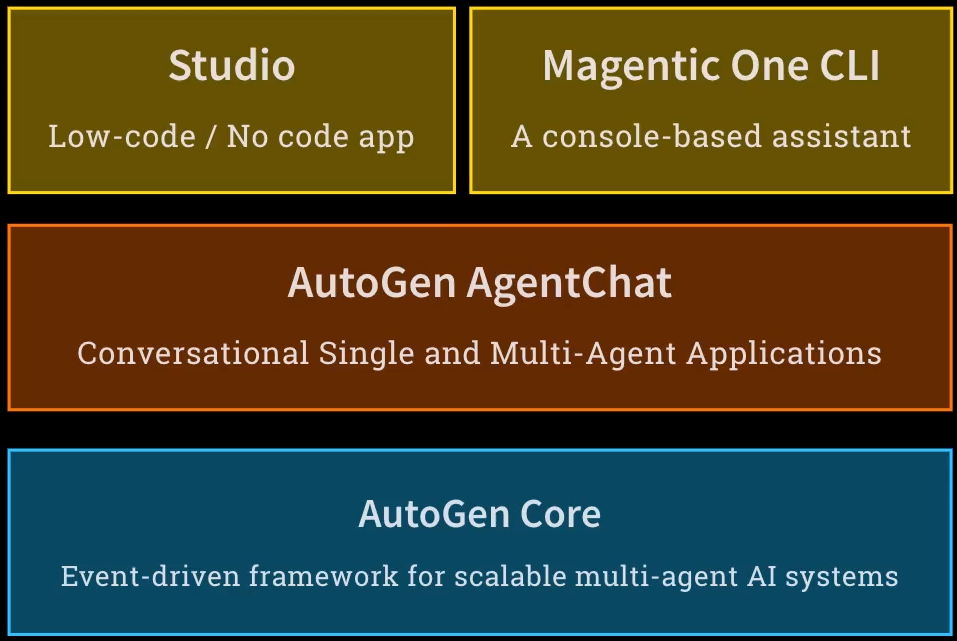